In [11]:
import json
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import cohen_kappa_score


def load_predictions(predictions_file):
    """
    Load predictions from the first JSON file.
    Returns a dictionary with keys as (idx1, idx2) tuples and values as prediction indices.
    """
    with open(predictions_file, 'r') as f:
        predictions = json.load(f)
    
    pred_dict = {}
    for entry in predictions:
        key = (entry['idx1'], entry['idx2'])
        pred_dict[key] = entry['prediction']
    
    return pred_dict

def load_evaluations(evaluations_file):
    """
    Load evaluations from the second JSON file.
    Returns a dictionary with keys as (feature1_idx, feature2_idx) tuples and values as evaluation details.
    """
    with open(evaluations_file, 'r') as f:
        evaluations = json.load(f)
    
    eval_dict = {}
    for pair_key, details in evaluations['evaluations'].items():
        key = (details['feature1_idx'], details['feature2_idx'])
        eval_dict[key] = details
    
    return eval_dict

def map_rater1_predictions(pred_dict, eval_dict):
    """
    Map Rater 1's predictions to selection numbers (1 or 2) based on feature indices.
    Returns a dictionary with keys as pair tuples and values as 1 or 2.
    """
    rater1_selection = {}
    for key, pred in pred_dict.items():
        if key in eval_dict:
            feature1, feature2 = key
            if pred == feature1:
                rater1_selection[key] = 1
            elif pred == feature2:
                rater1_selection[key] = 2
            else:
                # Handle cases where prediction doesn't match either feature
                # Assign None or handle as per requirements
                rater1_selection[key] = None
        else:
            # Pair not found in evaluations; skip or handle accordingly
            pass
    return rater1_selection

def map_rater2_predictions(eval_dict):
    """
    Infer Rater 2's selections based on the 'correct' flag.
    If 'correct' is True, Rater 2 selected 'correct_index'.
    If 'correct' is False, Rater 2 selected the other index.
    Returns a dictionary with keys as pair tuples and values as 1 or 2.
    """
    rater2_selection = {}
    for key, details in eval_dict.items():
        feature1, feature2 = key
        correct_idx = details['correct_index']
        if details['correct']:
            selected_feature = correct_idx
        else:
            # Select the other index
            selected_feature = feature2 if correct_idx == feature1 else feature1
        
        if selected_feature == feature1:
            rater2_selection[key] = 1
        elif selected_feature == feature2:
            rater2_selection[key] = 2
        else:
            # Handle unexpected cases
            rater2_selection[key] = None
    return rater2_selection

def compute_inter_rater_reliability(r1, r2):
    """
    Compute Cohen's Kappa for inter-rater reliability.
    """
    # Ensure both raters have the same set of pairs
    common_keys = set(r1.keys()).intersection(set(r2.keys()))
    r1_labels = []
    r2_labels = []
    for key in common_keys:
        if r1[key] is not None and r2[key] is not None:
            r1_labels.append(r1[key])
            r2_labels.append(r2[key])
    
    if not r1_labels:
        print("No overlapping valid predictions to compare.")
        return None
    
    kappa = cohen_kappa_score(r1_labels, r2_labels)
    return kappa

def compute_accuracy(r1, r2, eval_dict):
    """
    Compute the accuracy of both raters against the ground truth.
    Returns a tuple (r1_accuracy, r2_accuracy).
    """
    r1_correct = []
    r2_correct = []
    r1_labels = []
    r2_labels = []
    
    for key, details in eval_dict.items():
        # Rater 1
        if key in r1 and r1[key] is not None:
            r1_prediction_idx = key[0] if r1[key] == 1 else key[1]
            is_correct = int(r1_prediction_idx == details['correct_index'])
            r1_labels.append(is_correct)
        
        # Rater 2
        if key in r1 and r2[key] is not None:
            r2_prediction_idx = key[0] if r2[key] == 1 else key[1]
            is_correct = int(r2_prediction_idx == details['correct_index'])
            r2_labels.append(is_correct)
    
    # Calculate accuracies
    print('total human labels', len(r1_labels))
    print('total gpt labels', len(r2_labels))
    r1_accuracy = (sum(r1_labels) / len(r1_labels)) if r1_labels else 0
    r2_accuracy = (sum(r2_labels) / len(r2_labels)) if r2_labels else 0
    
    return r1_accuracy, r2_accuracy

def evaluate_interrater(pred_file, eval_file):
    # Load JSON files
    pred_dict = load_predictions(pred_file)
    eval_dict = load_evaluations(eval_file)
    
    # Map predictions to selections
    rater1 = map_rater1_predictions(pred_dict, eval_dict)
    rater2 = map_rater2_predictions(eval_dict)
    
    # Compute Inter-Rater Reliability
    kappa = compute_inter_rater_reliability(rater1, rater2)
    if kappa is not None:
        print(f"Inter-Rater Reliability (Cohen's Kappa): {kappa:.4f}")
    else:
        print("Unable to compute Cohen's Kappa due to lack of overlapping valid predictions.")
    
    # Compute Accuracy
    r1_acc, r2_acc = compute_accuracy(rater1, rater2, eval_dict)
    print(f"Human Accuracy: {r1_acc*100:.2f}%")
    print(f"GPT-4o Accuracy: {r2_acc*100:.2f}%")


In [2]:
pred_file = '../cruft/ViT-3mil-topkk-32-experts-None_1aaa89/latents-2969600/images/predictions.json'
eval_file = '../cruft/ViT-3mil-topkk-32-experts-None_1aaa89/latents-2969600/images/gpt4_evaluations.json'

evaluate_interrater(pred_file, eval_file)

Inter-Rater Reliability (Cohen's Kappa): 0.8135
total human labels 35
total gpt labels 35
Human Accuracy: 91.43%
GPT-4o Accuracy: 88.57%


In [3]:
pred_file = '../cruft/ViT-3mil-topkk-32-experts-8_5d073c/latents-2969600/images/predictions.json'
eval_file = '../cruft/ViT-3mil-topkk-32-experts-8_5d073c/latents-2969600/images/gpt4_evaluations.json'

evaluate_interrater(pred_file, eval_file)

Inter-Rater Reliability (Cohen's Kappa): 0.8264
total human labels 35
total gpt labels 35
Human Accuracy: 94.29%
GPT-4o Accuracy: 97.14%


In [4]:
# aws s3 sync ./cruft/ViT-3mil-topkk-32-experts-None_1aaa89 s3://vit-sae-switch/images/ViT-3mil-topkk-32-experts-None_1aaa89
# aws s3 sync ./cruft/ViT-3mil-topkk-32-experts-8_5d073c s3://vit-sae-switch/images/ViT-3mil-topkk-32-experts-8_5d073c

SyntaxError: invalid decimal literal (1380679892.py, line 1)

In [18]:
base_dirs = [
    '../cruft/ViT-3mil-topkk-32-experts-8_5d073c/latents-2969600/images',
    '../cruft/ViT-3mil-topkk-32-experts-None_1aaa89/latents-2969600/images',
    '../cruft/ViT-3mil-relu-l1-0.0001_ed4f74/latents-2969600/images'
]

conditions = [
    'topk@32-switch',
    'topk@32',
    'relu@31'
]

outcome_dict = defaultdict(list)
for d, condition in zip(base_dirs, conditions):
    for seed in range(4):
        eval_file = f'{d}/s-{seed}-gpt4_evaluations.json'
        with open(eval_file, 'r') as f:
            eval_dict = json.load(f)

        print(condition, eval_dict["mean_correctness"])
        outcome_dict[condition].append(eval_dict["mean_correctness"])

topk@32-switch 0.8610478359908884
topk@32-switch 0.8606741573033708
topk@32-switch 0.8738738738738738
topk@32-switch 0.9123595505617977
topk@32 0.8714953271028038
topk@32 0.8697674418604651
topk@32 0.877030162412993
topk@32 0.8685446009389671
relu@31 0.6856435643564357
relu@31 0.6904761904761905
relu@31 0.7034313725490197
relu@31 0.7149643705463183


topk@32-switch 0.8769888544324828 0.021101390119626917
topk@32 0.8717093830788072 0.0032459010448606046
relu@31 0.6986288744819911 0.011456406012650225


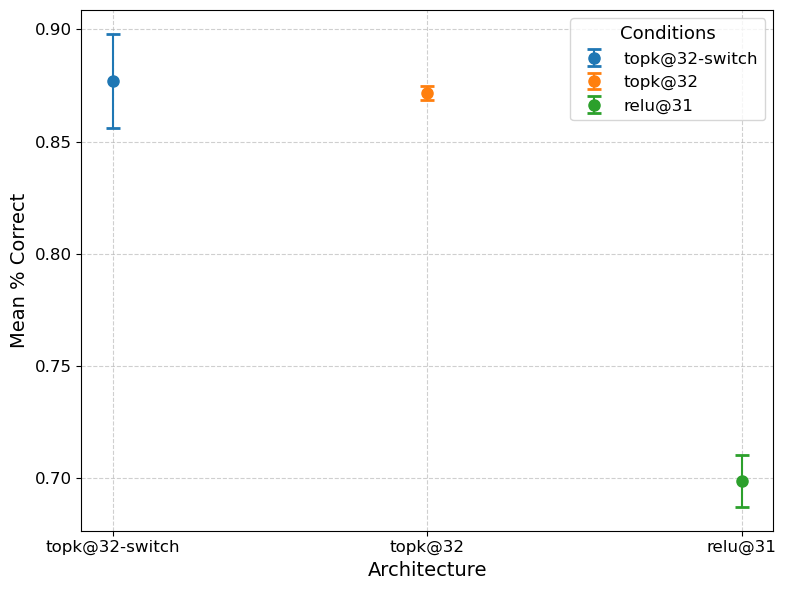

In [22]:
plt.figure(figsize=(8, 6))
for condition, outcomes in outcome_dict.items():
    mean = np.mean(outcomes)
    std = np.std(outcomes)
    print(condition, mean, std)
    plt.errorbar(condition, mean, yerr=std, fmt='o', capsize=5, capthick=2, markersize=8, label=condition)

# Beautify the plot
plt.xlabel('Architecture', fontsize=14)
plt.ylabel('Mean % Correct', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
# plt.axhline(0, color='grey', linewidth=0.8)  # Optional: add a horizontal line at y=0
plt.legend(title='Conditions', fontsize=12, title_fontsize='13')
plt.tight_layout()
plt.show()